In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_sift_detector_image_new_task3(img, nf, nOL, cT, eT, si):
    sift_create = cv2.SIFT_create(nfeatures=nf, nOctaveLayers=nOL, contrastThreshold=cT, edgeThreshold=eT, sigma=si)
    keypt, desc = sift_create.detectAndCompute(img, None)
    
    number_of_keypts = len(keypt)##'keypt' is a list
    
    reqd_keypts = int(0.1 * len(keypt))## reguired number of keypoints = 10/100 * keypoints in original image
    
    sift_create.setNFeatures(reqd_keypts)###setting nfeatures to required number of keypoints
    
    
    new_keypts, desc = sift_create.detectAndCompute(img, None) ##getting the new keypoints and descriptive features
    
    
    return new_keypts, desc

In [3]:
def negative_image(img):
    img_arr = np.zeros(img.shape, dtype=img.dtype)
    
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            for k in range(img_arr.shape[2]):
                img_arr[i][j][k] = 255 - img[i][j][k]
                
    return img_arr            

In [4]:
def Brute_Force_Matches(desc_neg, desc_img):
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

    matches = bf.match(desc_img,desc_neg)
    matches = sorted(matches, key = lambda x:x.distance)
    
    return matches

In [5]:
def img_with_bbox(matches, keypts, org_img):
    first_match_pts = []

    for i in matches:
        matching_coords = keypts[i.queryIdx].pt
        first_match_pts.append(matching_coords)

    keypoints_first = np.float32(first_match_pts).reshape(-1, 1, 2)
    
    x_coordinates = keypoints_first[:, 0, 0]
    y_coordinates = keypoints_first[:, 0, 1]

    max_x = np.max(x_coordinates)
    min_x = np.min(x_coordinates)
    
    max_y = np.max(y_coordinates)
    min_y = np.min(y_coordinates)
    
   
    cr_x_min = int(min_x)
    cr_y_min = int(min_y)
    cr_x_max = int(max_x)
    cr_y_max = int(max_y)
    
    img_copy = org_img.copy()
    ###showing the intersted portion of the image with bounding box
    cv2.rectangle(img_copy, (cr_x_min, cr_y_min), (cr_x_max, cr_y_max), (0, 0, 255), 2)
    

    return  img_copy, cr_x_min, cr_y_min, cr_x_max, cr_y_max

In [6]:
def Contour_Detect_Algo_OpenCV(img):
    
    ##Saving the Copy of the Image
    img_copy = img.copy()
    
    extra_img = img.copy()
    
    
    ##Step 1: Convert the Image to Grayscale
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    ##Step 2: Reversing the Intensity of the Image
    reverse_gray = cv2.bitwise_not(img_gray)
    
    #Step 3: Binary Thresholded Image formation with thresh=180
    _, img_binary = cv2.threshold(reverse_gray, 180, 255, cv2.THRESH_BINARY)
    
    
    #Step 4: finding all the contours from the thresholded image
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
   
    
    ##checking if the length of contours or number of contours > 0
    if len(contours) > 0:
        
        ###evaluating the largest area of the contour
        biggest_contour = max(contours, key = cv2.contourArea)
        
        cv2.drawContours(extra_img, biggest_contour, -1, (0, 0, 255), 4)
        
        
        ##getting the coordinates of the bounding box
        x, y, w, h = cv2.boundingRect(biggest_contour)
            
        x_min = x
        y_min = y
    
        x_max = x + w
        y_max = y + h
        
        #rectangle drawn around object
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 0, 255), 3)
        
        
    else:
        x_min = 0   ##if still number of contours detected in image is 0, returning original input image
        y_min = 0
        x_max = img_copy.shape[0]
        y_max = img_copy.shape[1]
    
    return extra_img, img_copy, x_min, y_min, x_max , y_max

In [7]:
def detection_T3_Demo(img):
    
    img_copy = img.copy()
    
    
    ##Step 1: Conversion to negative Image
    neg_img = negative_image(img)
    #plt.imshow(neg_img)
    
    ## Step 2: getting shift descriptor points from original image
    keypts_img, desc_img = create_sift_detector_image_new_task3(img, 0, 4, 0.04, 50, 1.67)
    
    ##Step 3: getting shift descriptor points from negative image
    keypts_neg_img, desc_neg = create_sift_detector_image_new_task3(neg_img, 0, 4, 0.04, 50, 1.67)
    
    ## Step4: finding matching keypoints between the negative and original image
    #matching_keypts = Matches_KNN(desc_neg, desc_img)
    matching_keypts = Brute_Force_Matches(desc_neg, desc_img)
    #plt.imshow(img)
    if len(matching_keypts) > 55:
        detected_img, x_min, y_min, x_max, y_max = img_with_bbox(matching_keypts, keypts_img, img)
    else:
        extra_img,detected_img, x_min, y_min, x_max, y_max =  Contour_Detect_Algo_OpenCV(img_copy)
        neg_img = extra_img.copy()
    
    return neg_img,detected_img, matching_keypts, x_min, y_min, x_max, y_max
        

###### First Method Detection on Image Id: 103

In [8]:
#import os
#directory = 'Penguins vs Turtles/archive/train/train'
#img_labels = os.listdir(directory)

#label = img_labels[12]

#img_path = os.path.join(directory, label)
image = cv2.imread(r'C:\Users\User\Penguins vs Turtles\archive\train\train\image_id_103.jpg')
img_clone = image.copy()
negative_img,bounded_image, num_of_common_keypts, x_min, y_min, x_max, y_max= detection_T3_Demo(img_clone)
print(len(num_of_common_keypts))

154


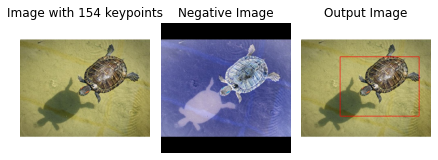

In [9]:
fig, axes = plt.subplots(1, 3)

# the original image in the first subplot
axes[0].imshow(image[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Image with '+ str(len(num_of_common_keypts))+' keypoints')


axes[1].imshow(negative_img[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Negative Image')

axes[2].imshow(bounded_image[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Output Image')


plt.tight_layout()

###### First Method Detection on Image Id: 118

In [10]:
image = cv2.imread(r'C:\Users\User\Penguins vs Turtles\archive\train\train\image_id_118.jpg')
img_clone = image.copy()
negative_img,bounded_image, num_of_common_keypts, x_min, y_min, x_max, y_max= detection_T3_Demo(img_clone)
print(len(num_of_common_keypts))

94


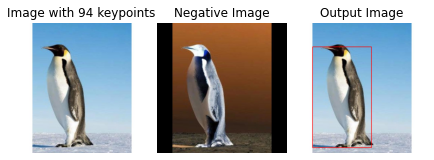

In [11]:
fig, axes = plt.subplots(1, 3)

# the original image in the first subplot
axes[0].imshow(image[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Image with '+ str(len(num_of_common_keypts))+' keypoints')


axes[1].imshow(negative_img[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Negative Image')

axes[2].imshow(bounded_image[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Output Image')


plt.tight_layout()

###### Second Method Detected on Image Id: 88

In [12]:
image = cv2.imread(r'C:\Users\User\Penguins vs Turtles\archive\train\train\image_id_088.jpg')
img_clone = image.copy()
negative_img,bounded_image, num_of_common_keypts, x_min, y_min, x_max, y_max= detection_T3_Demo(img_clone)
print(len(num_of_common_keypts))

4


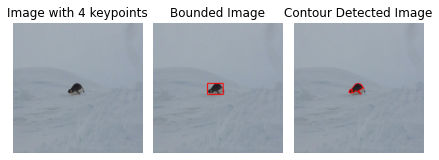

In [13]:
fig, axes = plt.subplots(1, 3)

# the original image in the first subplot
axes[0].imshow(image[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Image with '+ str(len(num_of_common_keypts))+' keypoints')

axes[1].imshow(bounded_image[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Bounded Image')

axes[2].imshow(negative_img[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Contour Detected Image')


plt.tight_layout()

###### Second Method Detected on Image Id: 258

In [14]:
image = cv2.imread(r'C:\Users\User\Penguins vs Turtles\archive\train\train\image_id_258.jpg')
img_clone = image.copy()
negative_img,bounded_image, num_of_common_keypts, x_min, y_min, x_max, y_max= detection_T3_Demo(img_clone)
print(len(num_of_common_keypts))

37


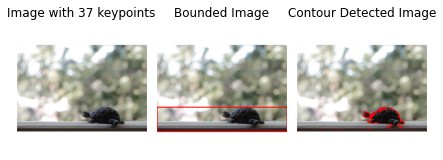

In [15]:
fig, axes = plt.subplots(1, 3)

# the original image in the first subplot
axes[0].imshow(image[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Image with '+ str(len(num_of_common_keypts))+' keypoints')

axes[1].imshow(bounded_image[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Bounded Image')

axes[2].imshow(negative_img[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Contour Detected Image')


plt.tight_layout()

##### IOU Metric Implementation Function

In [16]:
def estimate_intersect_area(pred_cords, actual_cords):
    
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_cords
    
    x_min_actual, y_min_actual, x_max_actual, y_max_actual = actual_cords
    
    ##common area in x-axis
    commomn_x_area = max(0, (min(x_max_pred, x_max_actual) - max(x_min_pred,  x_min_actual)))
    
    ##common-area in y-axis
    commomn_y_area = max(0, (min(y_max_pred, y_max_actual) - max(y_min_pred,  y_min_actual)))
    
    ##getting the common area between two images
    intersection_area = commomn_x_area * commomn_y_area

    
    return intersection_area

In [17]:
def estimate_union_area(pred_cords, actual_cords):
    
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_cords
    
    x_min_actual, y_min_actual, x_max_actual, y_max_actual = actual_cords
    
    
    area_pred =  (x_max_pred -  x_min_pred) * (y_max_pred - y_min_pred)
    
    area_actual = (x_max_actual -  x_min_actual) * (y_max_actual - y_min_actual)
    
    area_estimated_union = area_pred + area_actual - estimate_intersect_area(pred_cords, actual_cords)
    
    return area_estimated_union

In [18]:
def estimate_iou_calculate(pred_bbox, actual_bbox):
    
    area_intersected = estimate_intersect_area(pred_bbox, actual_bbox)
    area_union = estimate_union_area(pred_bbox, actual_bbox)
    estimate_iou = area_intersected / area_union
    return estimate_iou

### Some Figures with Bounding Boxes and IOU Scores detected in following figures

In [19]:
import os
import json
def loading_of_dataset(directory):
    imgs_dir = os.listdir(directory)
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Create a 3x3 subplot grid
    
    ##going through annotations folder in valid directory
    valid_annotations_dir = 'valid_annotations'
    
    ##going through the file and reading loading the contents
    with open(valid_annotations_dir, 'r') as f:
         valid_annotations_given = json.load(f)

    for i, label in enumerate(imgs_dir):
        if i >= 9:
            break  
        
        img_dir = os.path.join(directory, label)  # taking the full image directory
        image = cv2.imread(img_dir)
        img_rgb = image[:,:,::-1]
        negative_img, bounded_image, num_of_common_keypts, min_x, min_y, max_x, max_y = detection_T3_Demo(image)
        
        ##Getting particular file data
        x_min, y_min, width, height = valid_annotations_given[i]['bbox']
        
        ###Getting bounded by actaul bounding box
        cv2.rectangle(bounded_image, (x_min, y_min), ( x_min+width, y_min+height), (0, 255, 0), 3)
        
        iou_score = estimate_iou_calculate([min_x, min_y, max_x, max_y], [x_min, y_min, x_min+width, y_min+height])
        
        cv2.putText(bounded_image, "IoU: {:.4f}".format(iou_score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        

        row = i // 3
        col = i % 3
        axes[row, col].imshow(bounded_image[:, :, ::-1])  # Convert BGR to RGB for matplotlib
        axes[row, col].set_title(f'Image {i + 1} with IoU: {iou_score:.4f}')
        
        
        axes[row, col].axis('off')
    
    plt.tight_layout() 
    plt.show()

##### Detected Images by Proposed Detection Method - 1 on Validation Dataset

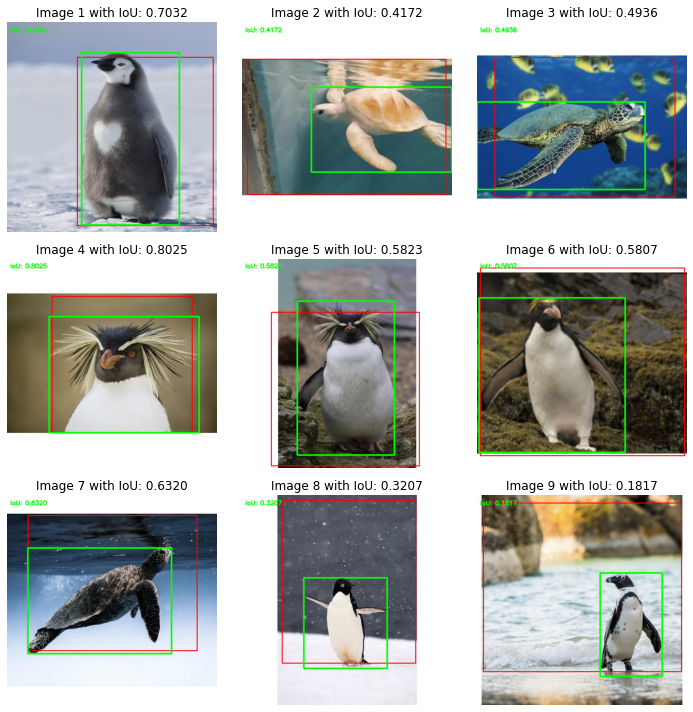

In [20]:
valid_directory = "Penguins vs Turtles/archive/valid/valid"
loading_of_dataset(valid_directory)